# Fast Speech I

# Imports

In [1]:
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

import time
import os

from tqdm import tqdm
from matplotlib import pyplot as plt


import seaborn as sns 
sns.set()

import sys
sys.path.append(".")
from text.symbols import symbols
from text import text_to_sequence

Mels and LJSpeech with text construction you can download [here](https://disk.yandex.ru/d/FwBnIRrsAYnbgQ), it is needed only for dataset construction.

The original code and the repository can be found [here](https://github.com/xcmyz/FastSpeech).

In [3]:
@dataclass
class MelSpectrogramConfig:
    num_mels = 80

@dataclass
class FastSpeechConfig:
    vocab_size = 300
    max_seq_len = 3000

    encoder_dim = 256
    encoder_n_layer = 4
    encoder_head = 2
    encoder_conv1d_filter_size = 1024

    decoder_dim = 256
    decoder_n_layer = 4
    decoder_head = 2
    decoder_conv1d_filter_size = 1024

    fft_conv1d_kernel = (9, 1)
    fft_conv1d_padding = (4, 0)

    duration_predictor_filter_size = 256
    duration_predictor_kernel_size = 3
    dropout = 0.1
    
    PAD = 0
    UNK = 1
    BOS = 2
    EOS = 3

    PAD_WORD = '<blank>'
    UNK_WORD = '<unk>'
    BOS_WORD = '<s>'
    EOS_WORD = '</s>'


@dataclass
class TrainConfig:
    checkpoint_path = "./model_new"
    logger_path = "./logger"
    mel_ground_truth = "./mels"
    alignment_path = "./FastSpeech/alignments"
    data_path = './data/train.txt'
    
    wandb_project = 'fastspeech_example' #not needed
    
    text_cleaners = ['english_cleaners']

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = "cpu"#'cuda:0'

    batch_size = 16
    epochs = 2000
    n_warm_up_step = 4000

    learning_rate = 1e-3
    weight_decay = 1e-6
    grad_clip_thresh = 1.0
    decay_step = [500000, 1000000, 2000000]

    save_step = 3000
    log_step = 5
    clear_Time = 20

    batch_expand_size = 32
    

mel_config = MelSpectrogramConfig()
model_config = FastSpeechConfig()
train_config = TrainConfig()

In [4]:


def pad_1D(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = np.pad(x, (0, length - x.shape[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = np.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded


def pad_1D_tensor(inputs, PAD=0):

    def pad_data(x, length, PAD):
        x_padded = F.pad(x, (0, length - x.shape[0]))
        return x_padded

    max_len = max((len(x) for x in inputs))
    padded = torch.stack([pad_data(x, max_len, PAD) for x in inputs])

    return padded


def pad_2D(inputs, maxlen=None):

    def pad(x, max_len):
        PAD = 0
        if np.shape(x)[0] > max_len:
            raise ValueError("not max_len")

        s = np.shape(x)[1]
        x_padded = np.pad(x, (0, max_len - np.shape(x)[0]),
                          mode='constant',
                          constant_values=PAD)
        return x_padded[:, :s]

    if maxlen:
        output = np.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(np.shape(x)[0] for x in inputs)
        output = np.stack([pad(x, max_len) for x in inputs])

    return output


def pad_2D_tensor(inputs, maxlen=None):

    def pad(x, max_len):
        if x.size(0) > max_len:
            raise ValueError("not max_len")

        s = x.size(1)
        x_padded = F.pad(x, (0, 0, 0, max_len-x.size(0)))
        return x_padded[:, :s]

    if maxlen:
        output = torch.stack([pad(x, maxlen) for x in inputs])
    else:
        max_len = max(x.size(0) for x in inputs)
        output = torch.stack([pad(x, max_len) for x in inputs])

    return output


def process_text(train_text_path):
    with open(train_text_path, "r", encoding="utf-8") as f:
        txt = []
        for line in f.readlines():
            txt.append(line)

        return txt


def get_data_to_buffer(train_config):
    buffer = list()
    text = process_text(train_config.data_path)

    start = time.perf_counter()
    for i in tqdm(range(len(text))):

        mel_gt_name = os.path.join(
            train_config.mel_ground_truth, "ljspeech-mel-%05d.npy" % (i+1))
        mel_gt_target = np.load(mel_gt_name)
        duration = np.load(os.path.join(
            train_config.alignment_path, str(i)+".npy"))
        character = text[i][0:len(text[i])-1]
        character = np.array(
            text_to_sequence(character, train_config.text_cleaners))

        character = torch.from_numpy(character)
        duration = torch.from_numpy(duration)
        mel_gt_target = torch.from_numpy(mel_gt_target)

        buffer.append({"text": character, "duration": duration,
                       "mel_target": mel_gt_target})

    end = time.perf_counter()
    print("cost {:.2f}s to load all data into buffer.".format(end-start))

    return buffer


class BufferDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer
        self.length_dataset = len(self.buffer)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        return self.buffer[idx]


def reprocess_tensor(batch, cut_list):
    texts = [batch[ind]["text"] for ind in cut_list]
    mel_targets = [batch[ind]["mel_target"] for ind in cut_list]
    durations = [batch[ind]["duration"] for ind in cut_list]

    length_text = np.array([])
    for text in texts:
        length_text = np.append(length_text, text.size(0))

    src_pos = list()
    max_len = int(max(length_text))
    for length_src_row in length_text:
        src_pos.append(np.pad([i+1 for i in range(int(length_src_row))],
                              (0, max_len-int(length_src_row)), 'constant'))
    src_pos = torch.from_numpy(np.array(src_pos))

    length_mel = np.array(list())
    for mel in mel_targets:
        length_mel = np.append(length_mel, mel.size(0))

    mel_pos = list()
    max_mel_len = int(max(length_mel))
    for length_mel_row in length_mel:
        mel_pos.append(np.pad([i+1 for i in range(int(length_mel_row))],
                              (0, max_mel_len-int(length_mel_row)), 'constant'))
    mel_pos = torch.from_numpy(np.array(mel_pos))

    texts = pad_1D_tensor(texts)
    durations = pad_1D_tensor(durations)
    mel_targets = pad_2D_tensor(mel_targets)

    out = {"text": texts,
           "mel_target": mel_targets,
           "duration": durations,
           "mel_pos": mel_pos,
           "src_pos": src_pos,
           "mel_max_len": max_mel_len}

    return out


def collate_fn_tensor(batch):
    len_arr = np.array([d["text"].size(0) for d in batch])
    index_arr = np.argsort(-len_arr)
    batchsize = len(batch)
    real_batchsize = batchsize // train_config.batch_expand_size

    cut_list = list()
    for i in range(train_config.batch_expand_size):
        cut_list.append(index_arr[i*real_batchsize:(i+1)*real_batchsize])

    output = list()
    for i in range(train_config.batch_expand_size):
        output.append(reprocess_tensor(batch, cut_list[i]))

    return output



In [ ]:
buffer = get_data_to_buffer(train_config) # make sure to have dataset at the locations (irrelevant for further discussion)

dataset = BufferDataset(buffer)

training_loader = DataLoader(
    dataset,
    batch_size=train_config.batch_expand_size * train_config.batch_size,
    shuffle=True,
    collate_fn=collate_fn_tensor,
    drop_last=True,
    num_workers=0
)

In [ ]:
batch = next(iter(training_loader))[0]

In [6]:
batch['text'].shape

torch.Size([16, 182])

# Encoder

## Transformer Block

### Scaled Dot Product Attention

Here we have computer q,k,v matricies and we should calc attention score and calc weighted value vectors

<img src="https://img-blog.csdnimg.cn/20190325121034288.png">

In [7]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):
        # q, k, v: [ (batch_size * n_heads) x seq_len x hidden_size ]
        # attn: [ (batch_size * n_heads) x seq_len x seq_len ]
        attn = self.softmax(torch.einsum("nik,njk->nij",q,k)/self.temperature)
        attn = self.dropout(attn)#DropConnect
        
        # output: [ (batch_size * n_heads) x seq_len x hidden_size ]
        out = torch.einsum("nij,njk->nik", attn, v)
        return out, attn

In [8]:
dot_product_attention = ScaledDotProductAttention(1)

q = torch.randn(4 * 4, 8, 4)
k = torch.randn(4 * 4, 8, 4)
v = torch.randn(4 * 4, 8, 4)

output, attn = dot_product_attention(q, k, v)

Let's visualize!

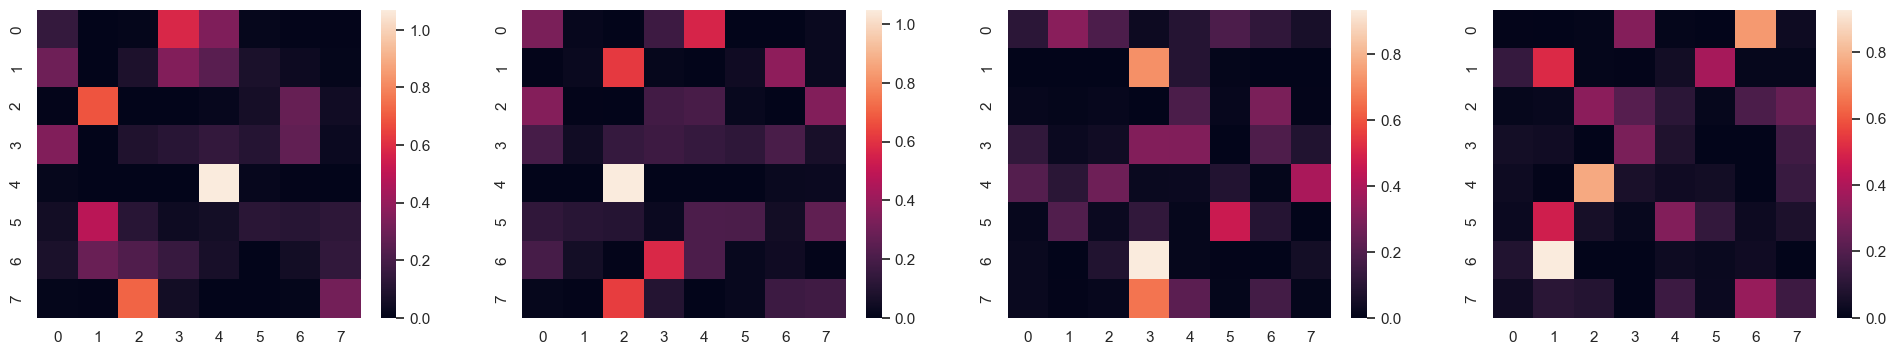

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(24, 4))
for i, at in enumerate(attn[0:4]):
    sns.heatmap(attn[i], ax=ax[i])

### Multi Head Attention

<img src='./images/attention_picture.png'>

Now, let's construct an MHA layer.

In [13]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.d_model = d_model

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)

        self.attention = ScaledDotProductAttention(
            temperature=d_k**0.5) 
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)
        
        self.reset_parameters()

    def reset_parameters(self):
         # normal distribution initialization better than kaiming(default in pytorch)
        nn.init.normal_(self.w_qs.weight, mean=0,
                        std=np.sqrt(2.0 / (self.d_model + self.d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0,
                        std=np.sqrt(2.0 / (self.d_model + self.d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0,
                        std=np.sqrt(2.0 / (self.d_model + self.d_v))) 
        
    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k)  # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k)  # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v)  # (n*b) x lv x dv
        
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)  # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1)  # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn

- Realization from Andrey Karpathy- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
- Flash Attention - https://arxiv.org/abs/2205.14135

### Positionwise Feed Forward

In [14]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()

        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in, d_hid, kernel_size=model_config.fft_conv1d_kernel[0], padding=model_config.fft_conv1d_padding[0])
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid, d_in, kernel_size=model_config.fft_conv1d_kernel[1], padding=model_config.fft_conv1d_padding[1])

        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)

        return output

### FFTBlock

<img src='./images/fft.png'>

Совмещаем все вместе в один FFT(Feed Forward Transformer) BLock. Теперь можно стакать эти слои

In [15]:
class FFTBlock(torch.nn.Module):
    """FFT Block"""

    def __init__(self,
                 d_model,
                 d_inner,
                 n_head,
                 d_k,
                 d_v,
                 dropout=0.1):
        super(FFTBlock, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(
            d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        
        if non_pad_mask is not None:
            enc_output *= non_pad_mask

        enc_output = self.pos_ffn(enc_output)
        
        if non_pad_mask is not None:
            enc_output *= non_pad_mask

        return enc_output, enc_slf_attn

In [16]:
hidden_size = 16
intermediate_size = 64
n_head = 4
batch_size = 4
seq_len = 12

fft_block = FFTBlock(hidden_size, intermediate_size, n_head, hidden_size // n_head, hidden_size // n_head)

inp_tensor = torch.rand(batch_size, seq_len, hidden_size, dtype=torch.float32)

out_tensor = fft_block(inp_tensor)[0]

assert inp_tensor.shape == out_tensor.shape

- Training tips - https://arxiv.org/pdf/1804.00247.pdf
- Transformer without Tears - https://tnq177.github.io/data/transformers_without_tears.pdf

## Length Regulator

### Aligner

In [17]:
def create_alignment(base_mat, duration_predictor_output):
    N, L = duration_predictor_output.shape
    for i in range(N):
        count = 0
        for j in range(L):
            for k in range(duration_predictor_output[i][j]):
                base_mat[i][count+k][j] = 1
            count = count + duration_predictor_output[i][j]
    return base_mat

Doubling each mel time frame is done via this function.

In [18]:
create_alignment(
    torch.zeros(1, 6, 3).numpy(),
    torch.LongTensor([[1,2,3]])
)

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]], dtype=float32)

### Duration Predictor

<img src='./images/duration_predictor.png'>

In [19]:
class Transpose(nn.Module):
    def __init__(self, dim_1, dim_2):
        super().__init__()
        self.dim_1 = dim_1
        self.dim_2 = dim_2

    def forward(self, x):
        return x.transpose(self.dim_1, self.dim_2)


Duration predictor is essentially a very simple fully-connected network trained on the regression problem (predicting the length of a phoneme, data is given from, say, Tacotron).

In [20]:
class DurationPredictor(nn.Module):
    """ Duration Predictor """

    def __init__(self, model_config: FastSpeechConfig):
        super(DurationPredictor, self).__init__()

        self.input_size = model_config.encoder_dim
        self.filter_size = model_config.duration_predictor_filter_size
        self.kernel = model_config.duration_predictor_kernel_size
        self.conv_output_size = model_config.duration_predictor_filter_size
        self.dropout = model_config.dropout

        self.conv_net = nn.Sequential(
            Transpose(-1, -2),
            nn.Conv1d(
                self.input_size, self.filter_size,
                kernel_size=self.kernel, padding=1
            ),
            Transpose(-1, -2),
            nn.LayerNorm(self.filter_size),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            Transpose(-1, -2),
            nn.Conv1d(
                self.filter_size, self.filter_size,
                kernel_size=self.kernel, padding=1
            ),
            Transpose(-1, -2),
            nn.LayerNorm(self.filter_size),
            nn.ReLU(),
            nn.Dropout(self.dropout)
        )

        self.linear_layer = nn.Linear(self.conv_output_size, 1)
        self.relu = nn.ReLU()

    def forward(self, encoder_output):
        encoder_output = self.conv_net(encoder_output)
            
        out = self.linear_layer(encoder_output)
        out = self.relu(out)
        out = out.squeeze()
        if not self.training:
            out = out.unsqueeze(0)
        return out

In [21]:
dur_predictor = DurationPredictor(model_config)

inp_tensor = torch.rand(
    2, # batch_size
    12, #seq_len
    model_config.encoder_dim,
    dtype=torch.float32
)

dur_prediction = dur_predictor(inp_tensor)

In [22]:
dur_prediction

tensor([[0.0000, 0.8276, 0.0733, 0.0547, 0.0000, 0.5168, 0.1581, 0.3389, 0.1272,
         0.0000, 0.7756, 0.2618],
        [0.2470, 0.1842, 0.3676, 0.2624, 0.1571, 0.3462, 0.4176, 0.2562, 0.0000,
         0.3322, 0.2456, 0.5668]], grad_fn=<SqueezeBackward0>)

In [23]:
class LengthRegulator(nn.Module):
    """ Length Regulator """

    def __init__(self, model_config):
        super(LengthRegulator, self).__init__()
        self.duration_predictor = DurationPredictor(model_config)

    def LR(self, x, duration_predictor_output, mel_max_length=None):
        expand_max_len = torch.max(
            torch.sum(duration_predictor_output, -1), -1)[0]
        alignment = torch.zeros(duration_predictor_output.size(0),
                                expand_max_len,
                                duration_predictor_output.size(1)).numpy()
        alignment = create_alignment(alignment,
                                     duration_predictor_output.cpu().numpy())
        alignment = torch.from_numpy(alignment).to(x.device)

        output = alignment @ x
        if mel_max_length:
            output = F.pad(
                output, (0, 0, 0, mel_max_length-output.size(1), 0, 0))
        return output

    def forward(self, x, alpha=1.0, target=None, mel_max_length=None):
        duration_predictor_output = self.duration_predictor(x)

        if target is not None:
            output = self.LR(x, target, mel_max_length=mel_max_length)
            return output, duration_predictor_output
        else:
            duration_predictor_output = (
                (duration_predictor_output + 0.5) * alpha).int()
            output = self.LR(x, duration_predictor_output)
            mel_pos = torch.stack(
                [torch.Tensor([i+1 for i in range(output.size(1))])]).long().to(device)

            return output, mel_pos        

Finally, we build the whole model on the high level.

## Final BLock

### Attention masks

In [24]:
def get_non_pad_mask(seq):
    assert seq.dim() == 2
    return seq.ne(model_config.PAD).type(torch.float).unsqueeze(-1)

def get_attn_key_pad_mask(seq_k, seq_q):
    ''' For masking out the padding part of key sequence. '''
    # Expand to fit the shape of key query attention matrix.
    len_q = seq_q.size(1)
    padding_mask = seq_k.eq(model_config.PAD)
    padding_mask = padding_mask.unsqueeze(
        1).expand(-1, len_q, -1)  # b x lq x lk

    return padding_mask

### Encoder

In [25]:
class Encoder(nn.Module):
    def __init__(self, model_config):
        super(Encoder, self).__init__()
        
        len_max_seq=model_config.max_seq_len
        n_position = len_max_seq + 1
        n_layers = model_config.encoder_n_layer

        self.src_word_emb = nn.Embedding(
            model_config.vocab_size,
            model_config.encoder_dim,
            padding_idx=model_config.PAD
        )

        self.position_enc = nn.Embedding(
            n_position,
            model_config.encoder_dim,
            padding_idx=model_config.PAD
        )

        self.layer_stack = nn.ModuleList([FFTBlock(
            model_config.encoder_dim,
            model_config.encoder_conv1d_filter_size,
            model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            dropout=model_config.dropout
        ) for _ in range(n_layers)])

    def forward(self, src_seq, src_pos, return_attns=False):

        enc_slf_attn_list = []

        # -- Prepare masks
        slf_attn_mask = get_attn_key_pad_mask(seq_k=src_seq, seq_q=src_seq)
        non_pad_mask = get_non_pad_mask(src_seq)
        
        # -- Forward
        enc_output = self.src_word_emb(src_seq) + self.position_enc(src_pos)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                enc_slf_attn_list += [enc_slf_attn]
        

        return enc_output, non_pad_mask

In [26]:
class Decoder(nn.Module):
    """ Decoder """

    def __init__(self, model_config):

        super(Decoder, self).__init__()

        len_max_seq=model_config.max_seq_len
        n_position = len_max_seq + 1
        n_layers = model_config.decoder_n_layer

        self.position_enc = nn.Embedding(
            n_position,
            model_config.encoder_dim,
            padding_idx=model_config.PAD,
        )

        self.layer_stack = nn.ModuleList([FFTBlock(
            model_config.encoder_dim,
            model_config.encoder_conv1d_filter_size,
            model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            model_config.encoder_dim // model_config.encoder_head,
            dropout=model_config.dropout
        ) for _ in range(n_layers)])

    def forward(self, enc_seq, enc_pos, return_attns=False):

        dec_slf_attn_list = []

        # -- Prepare masks
        slf_attn_mask = get_attn_key_pad_mask(seq_k=enc_pos, seq_q=enc_pos)
        non_pad_mask = get_non_pad_mask(enc_pos)

        # -- Forward
        dec_output = enc_seq + self.position_enc(enc_pos)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn = dec_layer(
                dec_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
            if return_attns:
                dec_slf_attn_list += [dec_slf_attn]

        return dec_output
    

In [27]:
def get_mask_from_lengths(lengths, max_len=None):
    if max_len == None:
        max_len = torch.max(lengths).item()

    ids = torch.arange(0, max_len, 1, device=lengths.device)
    mask = (ids < lengths.unsqueeze(1)).bool()

    return mask

In [28]:
class FastSpeech(nn.Module):
    """ FastSpeech """

    def __init__(self, model_config):
        super(FastSpeech, self).__init__()

        self.encoder = Encoder(model_config)
        self.length_regulator = LengthRegulator(model_config)
        self.decoder = Decoder(model_config)

        self.mel_linear = nn.Linear(model_config.decoder_dim, mel_config.num_mels)

    def mask_tensor(self, mel_output, position, mel_max_length):
        lengths = torch.max(position, -1)[0]
        mask = ~get_mask_from_lengths(lengths, max_len=mel_max_length)
        mask = mask.unsqueeze(-1).expand(-1, -1, mel_output.size(-1))
        return mel_output.masked_fill(mask, 0.)

    def forward(self, src_seq, src_pos, mel_pos=None, mel_max_length=None, length_target=None, alpha=1.0):
       
        encoder_output, _ = self.encoder(src_seq, src_pos)

        if self.training:
            length_regulator_output, duration_predictor_output = self.length_regulator(encoder_output,
                                                                                       target=length_target,
                                                                                       alpha=alpha,
                                                                                       mel_max_length=mel_max_length)
            decoder_output = self.decoder(length_regulator_output, mel_pos)

            mel_output = self.mel_linear(decoder_output)
            mel_output = self.mask_tensor(mel_output, mel_pos, mel_max_length)
            residual = self.postnet(mel_output)
            residual = self.last_linear(residual)
            mel_postnet_output = mel_output + residual
            mel_postnet_output = self.mask_tensor(mel_postnet_output,
                                                  mel_pos,
                                                  mel_max_length)

            return mel_output, mel_postnet_output, duration_predictor_output
        else:
            length_regulator_output, decoder_pos = self.length_regulator(encoder_output,
                                                                         alpha=alpha)

            decoder_output = self.decoder(length_regulator_output, decoder_pos)

            mel_output = self.mel_linear(decoder_output)
            residual = self.postnet(mel_output)
            residual = self.last_linear(residual)
            mel_postnet_output = mel_output + residual

            return mel_output, mel_postnet_output


## Loss

In [29]:
class FastSpeechLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

    def forward(self, mel, duration_predicted, mel_target, duration_predictor_target):
        mel_loss = self.mse_loss(mel, mel_target)

        duration_predictor_loss = self.l1_loss(duration_predicted,
                                               duration_predictor_target.float())

        return mel_loss, duration_predictor_loss
